## Point pro 

In [ ]:
# # !git clone https://github.com/apple/ml-depth-pro.git
# %cd ml-depth-pro

# # 2. Install the package
# !pip install -e .

# # 3. Download the pretrained models
# !bash get_pretrained_models.sh

#### Full pipeline from video to video

GPU (MPS) is available and will be used
Loading Depth Pro model and transforms...
Depth Pro model loaded.
Processing image: media/images/grab_banana.jpg
Depth estimation complete.
Generating point cloud...
Point cloud generated with 2506625 points.
Saving point cloud to media/generated_pointclouds/apple_depth_pro/grab_banana_adp.ply...
Point cloud saved successfully.
Displaying results...


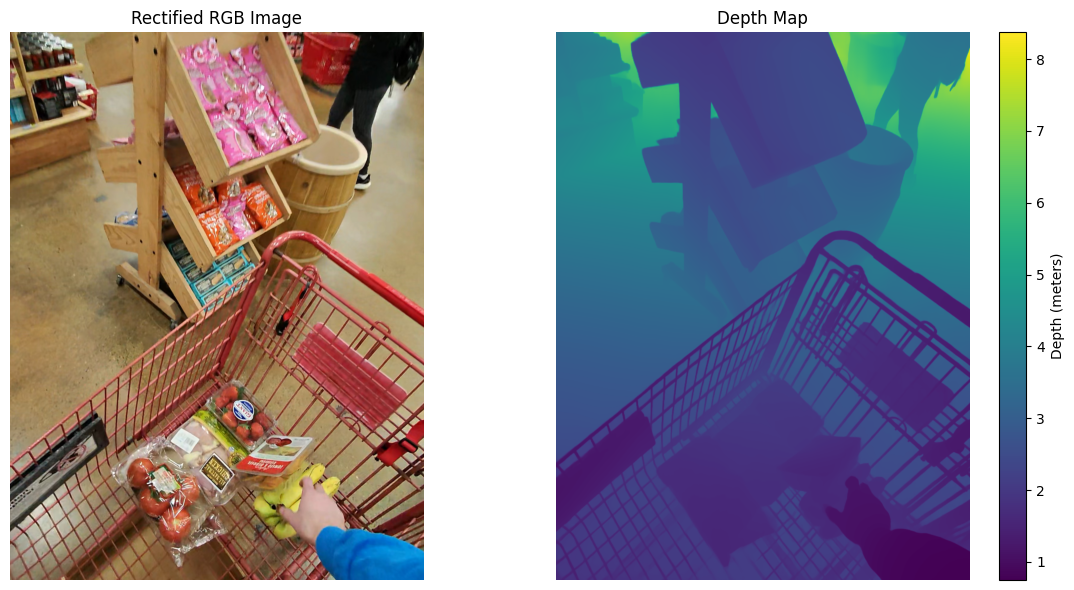

Visualizing Point Cloud (Close window to continue)...

Point Cloud Statistics:
Number of points: 2506625
X range: -3.96 to 0.08 meters
Y range: -6.65 to 0.10 meters
Z range: 0.75 to 8.37 meters (Depth)


2025-04-16 14:02:42.773 python[7850:131783] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-16 14:02:42.773 python[7850:131783] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [2]:
# Filename: apple_depth_pro_aligned.py (Suggested)

# import sys
# sys.path.append('./ml-depth-pro')
from depth_pro.depth_pro import * # Assuming create_model_and_transforms is here
from depth_pro.utils import *     # Assuming load_rgb might still be needed or adapted

import numpy as np
import torch
import matplotlib.pyplot as plt
import open3d as o3d
import os
import cv2
from PIL import Image
from pathlib import Path # Added

# --- Functions aligned with depth_anything structure ---

def get_device():
    """Get the best available device (MPS, CUDA, or CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU (CUDA) is available and will be used")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("GPU (MPS) is available and will be used")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU")
    return device

def rectify_image(image_path, camera_matrix, dist_coeffs):
    """Rectify, undistort, and crop a single image to the maximum valid rectangle."""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image at {image_path}")
        
    h, w = image.shape[:2]
    
    # Get the optimal new camera matrix and region of interest (ROI) with alpha=0
    # alpha=0 means the returned matrix ensures no black pixels are visible after undistortion
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 0, (w,h))
    
    # Undistort the image using the new optimal camera matrix
    undistorted = cv2.undistort(image, camera_matrix, dist_coeffs, None, newcameramtx)

    # Crop the image to the calculated ROI
    x, y, w_roi, h_roi = roi
    cropped_undistorted = undistorted[y:y+h_roi, x:x+w_roi]

    # Convert the *cropped* BGR image to RGB
    cropped_undistorted_rgb = cv2.cvtColor(cropped_undistorted, cv2.COLOR_BGR2RGB)

    return cropped_undistorted_rgb

def load_depth_model(config):
    """Load the Depth Pro model and transforms."""
    # This function directly replaces create_model_and_transforms
    # Assuming create_model_and_transforms returns (model, transform)
    print("Loading Depth Pro model and transforms...")
    model, transform = create_model_and_transforms(config=config)
    print("Depth Pro model loaded.")
    return model, transform

def estimate_depth(image_path, model, transform, device, camera_matrix, dist_coeffs):
    """Estimate depth from image using Depth Pro model."""
    # 1. Rectify the image first
    image_rgb_rectified = rectify_image(image_path, camera_matrix, dist_coeffs)

    # 2. Apply the model-specific transforms
    # The transform likely expects a PIL image or numpy array.
    # If load_rgb was essential for specific preprocessing not in transform,
    # it might need careful integration here. Assuming transform handles it:
    image_tensor = transform(image_rgb_rectified).to(device)

    # 3. Extract focal length (fx) from the camera matrix for Depth Pro's inference
    f_px = camera_matrix[0, 0]
    # If fx and fy differ significantly, Depth Pro might need adaptation
    # or averaging, but typically they are close for standard cameras.
    # print(f"Using fx = {f_px:.2f} from camera matrix for inference.") # Debug print

    # 4. Inference
    with torch.no_grad():
        # Ensure the input tensor has the batch dimension
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)

        # Run Depth Pro inference, passing the required focal length
        prediction = model.infer(image_tensor, f_px=f_px)
        predicted_depth = prediction["depth"] # Assuming this is the key

    # 5. Process prediction
    # Depth Pro might return depth on GPU, move to CPU and convert to numpy
    # Squeeze potential batch dimension if necessary
    depth_map_numpy = predicted_depth.squeeze().cpu().numpy()

    # No interpolation needed usually, Depth Pro often outputs at input resolution

    # Return the *rectified* RGB image and the depth map
    return image_rgb_rectified, depth_map_numpy

def create_point_cloud(rgb_image, depth_map, camera_intrinsics):
    """Convert RGB-D to point cloud using camera intrinsics."""
    # Get image dimensions
    height, width = depth_map.shape
    if rgb_image.shape[0] != height or rgb_image.shape[1] != width:
         raise ValueError("RGB image and depth map dimensions do not match!")

    # Extract intrinsics
    fx = camera_intrinsics[0, 0]
    fy = camera_intrinsics[1, 1]
    cx = camera_intrinsics[0, 2]
    cy = camera_intrinsics[1, 2]

    # Create meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Back-project to 3D using intrinsics
    z_3d = depth_map
    x_3d = (x - cx) * z_3d / fx
    y_3d = (y - cy) * z_3d / fy

    # Stack and reshape to points (N, 3)
    # Filter out invalid depth points (e.g., depth <= 0)
    valid_mask = z_3d > 0
    points = np.stack([x_3d[valid_mask], y_3d[valid_mask], z_3d[valid_mask]], axis=-1)

    # Reshape RGB image and filter colors corresponding to valid points
    colors = rgb_image[valid_mask].reshape(-1, 3) / 255.0 # Normalize colors to [0, 1]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Optional: Apply post-processing similar to Depth Anything script
    # print(f"Point cloud before processing: {len(pcd.points)} points")
    # pcd = pcd.voxel_down_sample(voxel_size=0.01)
    # pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    # print(f"Point cloud after processing: {len(pcd.points)} points")

    return pcd

def visualize_results(image, depth_map, point_cloud):
    """Visualize the original image (rectified), depth map, and point cloud."""
    # Create subplot for image and depth map
    fig = plt.figure(figsize=(12, 6)) # Adjusted size

    # Rectified RGB image
    ax = fig.add_subplot(121)
    ax.imshow(image)
    ax.set_title('Rectified RGB Image')
    ax.axis('off')

    # Depth map
    ax = fig.add_subplot(122)
    depth_vis = ax.imshow(depth_map, cmap='viridis') # Changed cmap to match ADP example
    ax.set_title('Depth Map')
    ax.axis('off')
    plt.colorbar(depth_vis, ax=ax, label='Depth (meters)') # Assuming depth is metric

    plt.tight_layout()
    plt.show()

    # Visualize point cloud using Open3D
    print("Visualizing Point Cloud (Close window to continue)...")
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3) # Coordinate frame for reference
    o3d.visualization.draw_geometries([point_cloud, coord_frame],
                                      window_name="Depth Pro Metric Point Cloud",
                                      width=1024,
                                      height=768)

# --- Main Execution Block ---

def main():
    # Parameters (Adjust as needed)
    image_path = "media/images/grab_banana.jpg"
    output_dir = "media/generated_pointclouds/apple_depth_pro" # Specific output dir
    output_filename = os.path.splitext(os.path.basename(image_path))[0] + "_adp.ply"
    output_path = os.path.join(output_dir, output_filename)

    # Use the corrected paths for intrinsics/distortion
    path_distortion = Path("/Users/hendrik/OMGrab/media/camera_intrinsics_extrinsics/Meta Rayban/distortion_coefficients.npy")
    path_intrinsics = Path("/Users/hendrik/OMGrab/media/camera_intrinsics_extrinsics/Meta Rayban/camera_intrinsics.npy")

    camera_matrix = np.load(path_intrinsics)
    dist_coeffs = np.load(path_distortion)

    # Define Depth Pro configuration (ensure checkpoint path is correct)
    DEFAULT_MONODEPTH_CONFIG_DICT = DepthProConfig(
        patch_encoder_preset="dinov2l16_384",
        image_encoder_preset="dinov2l16_384",
        # IMPORTANT: Update this path to the actual checkpoint location
        checkpoint_uri= "/Users/hendrik/OMGrab/ml-depth-pro/checkpoints/depth_pro.pt",
        decoder_features=256,
        use_fov_head=True,
        fov_encoder_preset="dinov2l16_384",
    )

    # 1. Setup Device
    device = get_device()

    # 2. Load model
    model, transform = load_depth_model(config=DEFAULT_MONODEPTH_CONFIG_DICT)
    model = model.to(device)
    model.eval()

    # 3. Estimate Depth (includes rectification)
    print(f"Processing image: {image_path}")
    try:
        image_rectified, depth_map = estimate_depth(image_path, model, transform, device, camera_matrix, dist_coeffs)
        print("Depth estimation complete.")
    except Exception as e:
        print(f"Error during depth estimation: {e}")
        return

    # 4. Create point cloud (using rectified image and intrinsics)
    print("Generating point cloud...")
    try:
        point_cloud = create_point_cloud(image_rectified, depth_map, camera_matrix)
        print(f"Point cloud generated with {len(point_cloud.points)} points.")
    except Exception as e:
        print(f"Error creating point cloud: {e}")
        return

    # 5. Save point cloud
    print(f"Saving point cloud to {output_path}...")
    os.makedirs(output_dir, exist_ok=True) # Ensure output directory exists
    try:
        o3d.io.write_point_cloud(output_path, point_cloud)
        print(f"Point cloud saved successfully.")
    except Exception as e:
        print(f"Error saving point cloud: {e}")
        # Continue to visualization even if saving fails? Optional.

    # 6. Visualize results
    print("Displaying results...")
    try:
        visualize_results(image_rectified, depth_map, point_cloud)
    except Exception as e:
        print(f"Error during visualization: {e}")

    # 7. Optional: Print statistics
    points = np.asarray(point_cloud.points)
    if len(points) > 0:
        print("\nPoint Cloud Statistics:")
        print(f"Number of points: {len(points)}")
        # Calculate bounds safely
        x_min, x_max = points[:,0].min(), points[:,0].max()
        y_min, y_max = points[:,1].min(), points[:,1].max()
        z_min, z_max = points[:,2].min(), points[:,2].max()
        print(f"X range: {x_min:.2f} to {x_max:.2f} meters")
        print(f"Y range: {y_min:.2f} to {y_max:.2f} meters")
        print(f"Z range: {z_min:.2f} to {z_max:.2f} meters (Depth)")
    else:
        print("\nPoint cloud is empty, cannot compute statistics.")

if __name__ == "__main__":
    main()

#### Point cloud from video

In [2]:
# Filename: apple_depth_pro_aligned.py (Suggested)

# import sys
# sys.path.append('./ml-depth-pro')
from depth_pro.depth_pro import * # Assuming create_model_and_transforms is here
from depth_pro.utils import *     # Assuming load_rgb might still be needed or adapted
import json
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import open3d as o3d
import os
import cv2
from PIL import Image
from pathlib import Path # Added

# --- Functions aligned with depth_anything structure ---

def get_device():
    """Get the best available device (MPS, CUDA, or CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU (CUDA) is available and will be used")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("GPU (MPS) is available and will be used")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU")
    return device

def rectify_image(image, camera_matrix, dist_coeffs):
    """Rectify, undistort, and crop a single image to the maximum valid rectangle."""
        
    h, w = image.shape[:2]
    
    # Get the optimal new camera matrix and region of interest (ROI) with alpha=0
    # alpha=0 means the returned matrix ensures no black pixels are visible after undistortion
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 0, (w,h))
    
    # Undistort the image using the new optimal camera matrix
    undistorted = cv2.undistort(image, camera_matrix, dist_coeffs, None, newcameramtx)

    # Crop the image to the calculated ROI
    x, y, w_roi, h_roi = roi
    cropped_undistorted = undistorted[y:y+h_roi, x:x+w_roi]

    return cropped_undistorted

def load_depth_model(config):
    """Load the Depth Pro model and transforms."""
    # This function directly replaces create_model_and_transforms
    # Assuming create_model_and_transforms returns (model, transform)
    print("Loading Depth Pro model and transforms...")
    model, transform = create_model_and_transforms(config=config)
    print("Depth Pro model loaded.")
    return model, transform

def extract_frames(video_path, skip_frames):
    """Extract frames from a video file, skipping frames according to skip_frame.
    
    Args:
        video_path (str): Path to the video file
        skip_frame (int): Number of frames to skip between extracted frames
        
    Returns:
        list: List of extracted frames as numpy arrays in RGB format
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video at {video_path}")
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % skip_frames == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            
        frame_count += 1
        
    cap.release()
    return frames

def estimate_depth(image, model, transform, device, camera_matrix, dist_coeffs):
    """Estimate depth from image using Depth Pro model."""
    # 1. Rectify the image first
    image_rgb_rectified = rectify_image(image, camera_matrix, dist_coeffs)

    # 2. Apply the model-specific transforms
    # The transform likely expects a PIL image or numpy array.
    # If load_rgb was essential for specific preprocessing not in transform,
    # it might need careful integration here. Assuming transform handles it:
    image_tensor = transform(image_rgb_rectified).to(device)

    # 3. Extract focal length (fx) from the camera matrix for Depth Pro's inference
    f_px = camera_matrix[0, 0]
    # If fx and fy differ significantly, Depth Pro might need adaptation
    # or averaging, but typically they are close for standard cameras.
    # print(f"Using fx = {f_px:.2f} from camera matrix for inference.") # Debug print

    # 4. Inference
    with torch.no_grad():
        # Ensure the input tensor has the batch dimension
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)

        # Run Depth Pro inference, passing the required focal length
        prediction = model.infer(image_tensor, f_px=f_px)
        predicted_depth = prediction["depth"] # Assuming this is the key

    # 5. Process prediction
    # Depth Pro might return depth on GPU, move to CPU and convert to numpy
    # Squeeze potential batch dimension if necessary
    depth_map_numpy = predicted_depth.squeeze().cpu().numpy()

    # No interpolation needed usually, Depth Pro often outputs at input resolution

    # Return the *rectified* RGB image and the depth map
    return image_rgb_rectified, depth_map_numpy

def create_point_cloud(rgb_image, depth_map, camera_intrinsics):
    """Convert RGB-D to point cloud using camera intrinsics."""
    # Get image dimensions
    height, width = depth_map.shape
    if rgb_image.shape[0] != height or rgb_image.shape[1] != width:
         raise ValueError("RGB image and depth map dimensions do not match!")

    # Extract intrinsics
    fx = camera_intrinsics[0, 0]
    fy = camera_intrinsics[1, 1]
    cx = camera_intrinsics[0, 2]
    cy = camera_intrinsics[1, 2]

    # Create meshgrid of pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Back-project to 3D using intrinsics
    z_3d = depth_map
    x_3d = (x - cx) * z_3d / fx
    y_3d = (y - cy) * z_3d / fy

    # Stack and reshape to points (N, 3)
    # Filter out invalid depth points (e.g., depth <= 0)
    valid_mask = z_3d > 0
    points = np.stack([x_3d[valid_mask], y_3d[valid_mask], z_3d[valid_mask]], axis=-1)

    # Reshape RGB image and filter colors corresponding to valid points
    colors = rgb_image[valid_mask].reshape(-1, 3) / 255.0 # Normalize colors to [0, 1]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Optional: Apply post-processing similar to Depth Anything script
    # print(f"Point cloud before processing: {len(pcd.points)} points")
    # pcd = pcd.voxel_down_sample(voxel_size=0.01)
    # pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    # print(f"Point cloud after processing: {len(pcd.points)} points")

    return pcd

def create_video_from_screenshots(
    screenshot_path,
    output_dir_video, 
    output_filename_video,
    width,
    height,
    fps
):
    """
    Create a video from a directory of screenshots/frames
    
    Args:
        screenshot_path (str): Path to directory containing frame images
        output_dir_video (str): Directory to save output video
        output_filename_video (str): Name of output video file
        width (int): Width of output video
        height (int): Height of output video 
        fps (int): Frames per second of output video
    """
    import cv2
    import os
    from glob import glob
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir_video, exist_ok=True)
    
    # Get list of frame files sorted numerically
    frame_files = sorted(glob(os.path.join(screenshot_path, "*.png")), 
                        key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    if not frame_files:
        raise Exception("No frame files found in screenshot directory")
        
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = os.path.join(output_dir_video, output_filename_video)
    out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
    
    # Add each frame to video
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            raise Exception(f"Could not read frame: {frame_file}")
        # Resize frame if needed
        frame = cv2.resize(frame, (width, height))
        out.write(frame)
        
    out.release()
    return out_path

def create_screenshots_from_point_clouds(screenshot_path, ply_dir, viewpoint_path):
    print("Loading point cloud using different viewers...")
    # Load saved viewpoint parameters from JSON file
    with open(viewpoint_path, 'r') as f:
        viewpoint_data = json.loads(f.read())

    # Extract camera parameters from the first trajectory point
    trajectory_point = viewpoint_data['trajectory'][0]

    # Convert parameters to numpy arrays as expected by draw_geometries
    lookat = np.array([0.0, 0.0, 0.0]) #np.array(trajectory_point['lookat'])
    up = np.array(trajectory_point['up'])
    front = np.array(trajectory_point['front'])
    zoom = float(trajectory_point['zoom']) # Ensure zoom is a float
    ply_files = sorted(glob.glob(os.path.join(ply_dir, "*.ply")), 
                    key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

    # Create screenshot directory if it doesn't exist
    os.makedirs(screenshot_path, exist_ok=True)

    # Add coordinate frame for context if desired
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

    # Create visualizer and set parameters
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Open3D Visualizer", width=1920, height=1080)
    # vis.add_geometry(coordinate_frame)

    # Process each point cloud
    for i, ply_path in enumerate(ply_files):
        print(f"\n--- Processing frame {i+1}/{len(ply_files)} ---")
        
        # Load point cloud
        pcd_o3d = o3d.io.read_point_cloud(ply_path)
        vis.add_geometry(pcd_o3d)
        
        # Set view parameters
        view_control = vis.get_view_control()
        view_control.set_lookat(lookat)
        view_control.set_up(up)
        view_control.set_front(front)
        view_control.set_zoom(zoom)

        # Update view
        vis.poll_events()
        vis.update_renderer()

        # Capture screenshot
        screenshot_filename = os.path.join(screenshot_path, f"frame_{i:04d}.png")
        print(f"Capturing screenshot to {screenshot_filename}...")
        vis.capture_screen_image(screenshot_filename, do_render=True)
        
        # Remove current point cloud before loading next one
        vis.remove_geometry(pcd_o3d)

    # Clean up
    vis.destroy_window()

    print("\nPoint cloud visualization complete.")

def main():
    # Parameters (Adjust as needed)
    video_path = "media/videos/1.5s clips/cashier/cashier_clip_001.mp4"
    screenshot_path = "media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots"
    output_dir_video = "media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier"
    output_filename_video = os.path.splitext(os.path.basename(video_path))[0] + "_adp.mp4"
    ply_dir = "media/generated_pointclouds/apple_depth_pro/1.5s clips/cashier"
    viewpoint_path = "media/camera_intrinsics_extrinsics/Meta Rayban/saved_viewpoint.json"
    skip_frames = 1

    # Verify and create directories if they don't exist
    os.makedirs(os.path.dirname(video_path), exist_ok=True)
    os.makedirs(screenshot_path, exist_ok=True) 
    os.makedirs(output_dir_video, exist_ok=True)
    os.makedirs(ply_dir, exist_ok=True)
    os.makedirs(os.path.dirname(viewpoint_path), exist_ok=True)

    # Use the corrected paths for intrinsics/distortion
    path_distortion = Path("/Users/hendrik/OMGrab/media/camera_intrinsics_extrinsics/Meta Rayban/distortion_coefficients.npy")
    path_intrinsics = Path("/Users/hendrik/OMGrab/media/camera_intrinsics_extrinsics/Meta Rayban/camera_intrinsics.npy")
    camera_matrix = np.load(path_intrinsics)
    dist_coeffs = np.load(path_distortion)

    # Define Depth Pro configuration (ensure checkpoint path is correct)
    DEFAULT_MONODEPTH_CONFIG_DICT = DepthProConfig(
        patch_encoder_preset="dinov2l16_384",
        image_encoder_preset="dinov2l16_384",
        # IMPORTANT: Update this path to the actual checkpoint location
        checkpoint_uri= "/Users/hendrik/OMGrab/ml-depth-pro/checkpoints/depth_pro.pt",
        decoder_features=256,
        use_fov_head=True,
        fov_encoder_preset="dinov2l16_384",
    )

    # 1. Setup Device
    device = get_device()

    # 2. Load model
    model, transform = load_depth_model(config=DEFAULT_MONODEPTH_CONFIG_DICT)
    model = model.to(device)
    model.eval()

    # 3. Estimate Depth (includes rectification)
    images = extract_frames(video_path, skip_frames)

    # 4. Create point clouds
    for index, image in enumerate(images):
        print(f"Processing frame {index+1}/{len(images)}")
        image_rectified, depth_map = estimate_depth(image, model, transform, device, camera_matrix, dist_coeffs)
        point_cloud = create_point_cloud(image_rectified, depth_map, camera_matrix)
        o3d.io.write_point_cloud(os.path.join(ply_dir, f"frame_{index}.ply"), point_cloud)

    # 5 Create screenshots from point clouds
    create_screenshots_from_point_clouds(screenshot_path, ply_dir, viewpoint_path)
    
    # 7 Create video from screenshots
    try:
        output_path = create_video_from_screenshots(
            screenshot_path,  # Point cloud directory 
            output_dir_video,  # Output directory
            output_filename_video,  # Output filename
            1920,  # Width
            1920,  # Height 
            30     # FPS
        )
        print("Video saved to: ", output_path)
    except Exception as e:
        print(f"Error generating video: {e}")

if __name__ == "__main__":
    main()

GPU (MPS) is available and will be used
Loading Depth Pro model and transforms...
Depth Pro model loaded.
Processing frame 1/45
Processing frame 2/45
Processing frame 3/45
Processing frame 4/45
Processing frame 5/45
Processing frame 6/45
Processing frame 7/45
Processing frame 8/45
Processing frame 9/45
Processing frame 10/45
Processing frame 11/45
Processing frame 12/45
Processing frame 13/45
Processing frame 14/45
Processing frame 15/45
Processing frame 16/45
Processing frame 17/45
Processing frame 18/45
Processing frame 19/45
Processing frame 20/45
Processing frame 21/45
Processing frame 22/45
Processing frame 23/45
Processing frame 24/45
Processing frame 25/45
Processing frame 26/45
Processing frame 27/45
Processing frame 28/45
Processing frame 29/45
Processing frame 30/45
Processing frame 31/45
Processing frame 32/45
Processing frame 33/45
Processing frame 34/45
Processing frame 35/45
Processing frame 36/45
Processing frame 37/45
Processing frame 38/45
Processing frame 39/45
Proces

2025-04-22 12:08:20.977 python[5152:44700] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-22 12:08:20.977 python[5152:44700] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0000.png...

--- Processing frame 2/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0001.png...

--- Processing frame 3/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0002.png...

--- Processing frame 4/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0003.png...

--- Processing frame 5/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0004.png...

--- Processing frame 6/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots/frame_0005.png...

--- Processing frame 7/45 ---
Capturing screenshot to media/generated_pointcloud_videos/apple_depth_pro/1.

In [95]:
def create_video_from_screenshots(
    screenshot_path,
    output_dir_video, 
    output_filename_video,
    width,
    height,
    fps
):
    """
    Create a video from a directory of screenshots/frames
    
    Args:
        screenshot_path (str): Path to directory containing frame images
        output_dir_video (str): Directory to save output video
        output_filename_video (str): Name of output video file
        width (int): Width of output video
        height (int): Height of output video 
        fps (int): Frames per second of output video
    """
    import cv2
    import os
    from glob import glob
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir_video, exist_ok=True)
    
    # Get list of frame files sorted numerically
    frame_files = sorted(glob(os.path.join(screenshot_path, "*.png")), 
                        key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    if not frame_files:
        raise Exception("No frame files found in screenshot directory")
        
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_path = os.path.join(output_dir_video, output_filename_video)
    out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
    
    # Add each frame to video
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            raise Exception(f"Could not read frame: {frame_file}")
        # Resize frame if needed
        frame = cv2.resize(frame, (width, height))
        out.write(frame)
        
    out.release()
    return out_path

screenshot_path = "media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier/screenshots"
output_dir_video = "media/generated_pointcloud_videos/apple_depth_pro/1.5s clips/cashier"
video_path = "media/videos/1.5s clips/cashier/cashier_clip_001.mp4"
output_filename_video = os.path.splitext(os.path.basename(video_path))[0] + "_adp.mp4"

print("Generating video from point clouds...")
try:
        create_video_from_screenshots(
            screenshot_path,  # Point cloud directory 
            output_dir_video,  # Output directory
            output_filename_video,  # Output filename
            1920,  # Width
            1920,  # Height 
            30     # FPS
        )
        print("Video generation complete.")
except Exception as e:
        print(f"Error generating video: {e}")

Generating video from point clouds...
Video generation complete.


#### Single point cloud visualization

In [ ]:
# Import required libraries
import open3d as o3d
import numpy as np
import trimesh
import json
import os # Import os for path joining

print("Loading point cloud using different viewers...")

# Load saved viewpoint parameters from JSON file
with open('saved_viewpoint.json', 'r') as f:
    viewpoint_data = json.loads(f.read())

# Extract camera parameters from the first trajectory point
trajectory_point = viewpoint_data['trajectory'][0]

# Create visualizer and window
vis = o3d.visualization.Visualizer()
vis.create_window()

# Load and add point cloud
print("\n--- Open3D Viewer ---")
ply_path = "media/generated_pointclouds/apple_depth_pro/1.5s clips/frame_14.ply"
pcd_o3d = o3d.io.read_point_cloud(ply_path)
print(f"Point cloud loaded with {len(pcd_o3d.points)} points from {ply_path}")

# Check if colors are loaded
if pcd_o3d.has_colors():
    print("Point cloud has color information.")
else:
    print("Point cloud does NOT have color information. The .ply file might be missing colors.")

vis.add_geometry(pcd_o3d)

# Add coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
vis.add_geometry(coordinate_frame)

# Get render options
render_option = vis.get_render_option()

# Explicitly set render option to use point colors
render_option.point_color_option = o3d.visualization.PointColorOption.Color

# Disable lighting
print("Disabling lighting...")
render_option.light_on = False

# Set the view parameters
print("Setting view parameters...")
view_control = vis.get_view_control()
view_control.set_front(trajectory_point['front'])
view_control.set_lookat(trajectory_point['lookat'])
view_control.set_up(trajectory_point['up'])
view_control.set_zoom(trajectory_point['zoom'])

# Force update of geometry and rendering state
print("Polling events and updating renderer to apply view...")
vis.poll_events()
vis.update_renderer()

# Run the visualizer
print("Starting interactive visualizer...")
vis.run()
vis.destroy_window()

print("\nPoint cloud visualization complete.")

Loading point cloud using different viewers...

--- Open3D Viewer ---
Point cloud loaded with 2506625 points from media/generated_pointclouds/apple_depth_pro/1.5s clips/frame_14.ply
Point cloud has color information.
Disabling lighting...
Setting view parameters...
Polling events and updating renderer to apply view...
Starting interactive visualizer...

Point cloud visualization complete.


#### Generate screenshots from point clouds